Reference image :  Documents/Github:Python/PlantHealth/planthealth/tests/Images/RGB.png
Image to align :  Documents/Github:Python/PlantHealth/planthealth/tests/Images/NGB.png
Aligned image :  aligned.jpg
Total Time = 1.37815499306


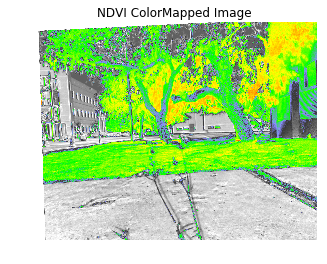

In [14]:
from __future__ import print_function
import cv2
import numpy as np
from time import time
from scipy.ndimage.interpolation import shift
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift
from scipy.ndimage.interpolation import shift
import sys
sys.path.append('Documents/Github:Python/PlantHealth/planthealth')
from core import *
from utils import channelSplit
init('Documents/Github:Python/PlantHealth/planthealth/cmap.csv')

t_elapsed = 0
starttime=time()

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
 
def alignImages(im1, im2):
 
  # Convert images to grayscale
  im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  
  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(MAX_FEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
   
  # Match features.
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)
   
  # Sort matches by score.
  matches.sort(key=lambda x: x.distance, reverse=False)
 
  # Remove not so good matches.
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]
 
  # Draw top matches.
  imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
  cv2.imwrite("matches.jpg", imMatches)
   
  # Extract location of good matches.
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)
    
  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
    

  #print("Points 1", points1) 
  #print("Points 2", points2) 
    
  # Find homography.
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
  # Use homography.
  height, width, channels = im2.shape
  im1Reg = cv2.warpPerspective(im1, h, (width, height))

    
  shiftXY, error, diffphase = register_translation(Rimg, NIRoff) 

  # Shifts first element by second element amount
  NIRimg = shift(NIRoff, np.array(shiftXY))
  NDVIimg = ndvi_map(Rimg, NIRimg)
    
  # Plot NDVI ColorMapped Image
  #plt.imshow(NDVIimg)
  #plt.axis('off')
  #plt.title('NDVI ColorMapped Image')
    
  return im1Reg, h
 
    
if __name__ == '__main__':
   
  # Read reference image
  #refFilename = 'Documents/Poster.jpg'
  refFilename='Documents/Github:Python/PlantHealth/planthealth/tests/Images/RGB.png'
  print("Reference image : ", refFilename)
  imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)
  [b, g, r] = cv2.split(imReference)
 
  # Read image to be aligned
  #imFilename = 'Documents/Poster2.jpg'
  imFilename = 'Documents/Github:Python/PlantHealth/planthealth/tests/Images/NGB.png'
  print("Image to align : ", imFilename);  
  im = cv2.imread(imFilename, cv2.IMREAD_COLOR)
  [b2, g2, r2] = cv2.split(im)

  Rimg = r #red pixel set from pi camera
  NIRoff = r2 #NIR pixel set from NOIR camera

  # Registered image will be restored in imReg. 
  # The estimated homography will be stored in h. 
  imReg, h = alignImages(im, imReference)
   
  # Write aligned image to disk. 
  outFilename = "aligned.jpg"
  print("Aligned image : ", outFilename); 
  cv2.imwrite(outFilename, imReg)
   
    #color map with Jessi's registered
  [b, g, NIRimg] = cv2.split(imReg)
  NDVIimg = ndvi_map(Rimg, NIRimg)
    # Plot NDVI ColorMapped Image
  plt.imshow(NDVIimg)
  plt.axis('off')
  plt.title('NDVI ColorMapped Image')
  
 
  # Print estimated homography
  #print("Estimated homography : \n",  h)

# Show images
  from PIL import Image
image1 = Image.open('Documents/Github:Python/PlantHealth/planthealth/tests/Images/RGB.png')
image1.show()
image2 = Image.open('Documents/Github:Python/PlantHealth/planthealth/tests/Images/NGB.png')
image2.show()
aligned = Image.open('aligned.jpg')
aligned.show()
matches= Image.open('matches.jpg')
matches.show()

# Time tracking of execution
t_elapsed = time()-starttime
print("Total Time = "+ str(t_elapsed))